In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint

# As the dataset is divided into folders
from tensorflow.keras.preprocessing.image import ImageDataGenerator

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
tf.__version__

'2.12.0'

# Creating Dataset

In [3]:
w,h = 400,400
batch_size = 32

train_path = '/kaggle/input/chest-xray-pneumoniacovid19tuberculosis/train'
test_path = '/kaggle/input/chest-xray-pneumoniacovid19tuberculosis/test'
val_path = '/kaggle/input/chest-xray-pneumoniacovid19tuberculosis/val'

train_img_gen = ImageDataGenerator(
    rescale = 1.0/255,
    rotation_range = 10,
    zoom_range=0.15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True
)

test_img_gen = ImageDataGenerator(
    rescale = 1.0/255
)

val_img_gen = ImageDataGenerator(
    rescale = 1.0/255
)

train_dataset = train_img_gen.flow_from_directory(
    train_path,
    target_size = (w,h),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = True
)

test_dataset = test_img_gen.flow_from_directory(
    test_path,
    target_size = (w,h),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False
)

val_dataset = val_img_gen.flow_from_directory(
    val_path,
    target_size = (w,h),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False
)

Found 6326 images belonging to 4 classes.
Found 771 images belonging to 4 classes.
Found 38 images belonging to 4 classes.


In [4]:
train_dataset.class_indices

{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2, 'TURBERCULOSIS': 3}

# View Images

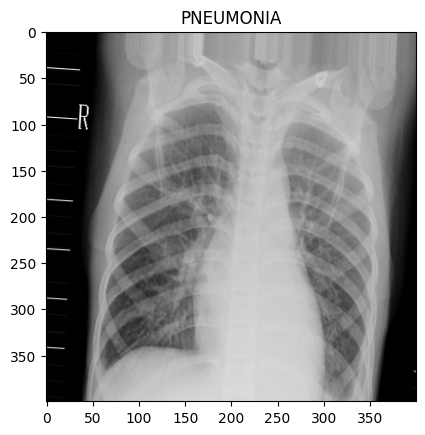

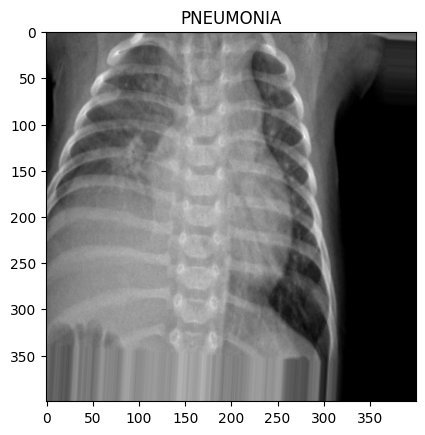

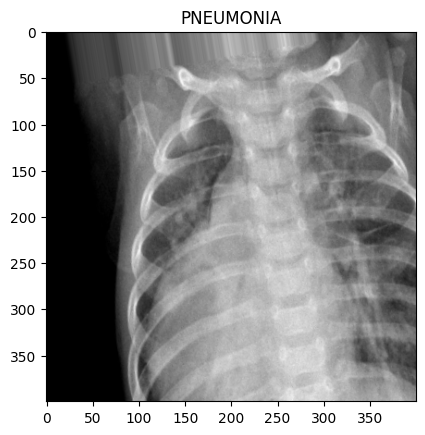

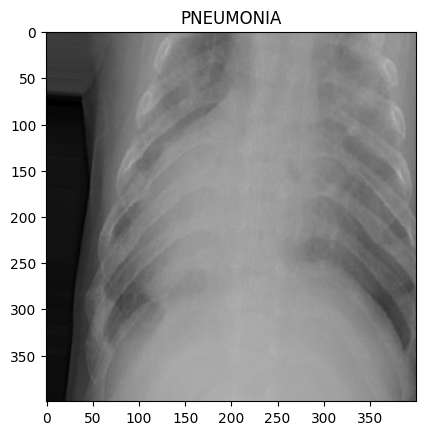

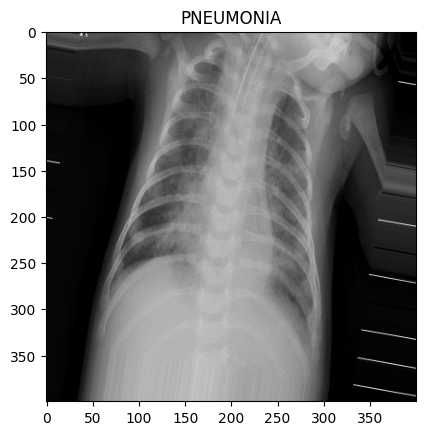

In [5]:
classes = ['COVID19', 'NORMAL', 'PNEUMONIA', 'TB']

for _ in range(5):
    img, label = train_dataset.next()
    plt.title(classes[np.argmax(label[0])])
    plt.imshow(img[0])
    plt.show()

In [6]:
train_dataset.image_shape

(400, 400, 3)

# CNN

In [7]:
# model = models.Sequential()

# # Convolutional layers
# model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(w, h, 3)))
# model.add(layers.MaxPooling2D((2, 2)))

# # Flatten layer
# model.add(layers.Flatten())

# # Dense layers
# model.add(layers.Dense(128, activation='relu'))
# model.add(layers.Dropout(0.2))  # dropout to avoid overfitting
# model.add(layers.Dense(4, activation='softmax'))  # softmax is used as it is a multiclass problem

# # Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # Print a summary of the model architecture
# model.summary()

# Deep CNN (DCNN)

In [8]:
model= models.Sequential()

model.add(layers.Conv2D(filters=128,strides= 1, kernel_size = (5,5), activation='relu', input_shape=(224,224,3,)))
model.add(layers.MaxPool2D(3,3))
model.add(layers.Conv2D(filters=64,kernel_size = (5,5),activation='relu'))
model.add(layers.MaxPool2D(3,3))

model.add(layers.Conv2D(filters=30,kernel_size = (3,3),activation='relu'))
model.add(layers.MaxPool2D(2,2))
model.add(layers.Conv2D(filters=30,kernel_size = (3,3),activation='relu'))
model.add(layers.MaxPool2D(2,2))

model.add(layers.Flatten())
model.add(layers.Dense(2048,activation='relu'))
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dropout(.1))
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dropout(.1))
model.add(layers.Dense(32,activation='relu'))
model.add(layers.Dense(4,activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer ='adam', metrics= ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 128)     9728      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 69, 69, 64)        204864    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 30)        17310     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 10, 30)       0

# MobileNet_v3

In [4]:
mobilenetModel = models.Sequential()

mobilenetv3 = tf.keras.applications.MobileNetV3Large(
                include_top = False,
                weights="imagenet",
                input_shape=(w,h,3),
                pooling='avg',
                classes=4,
                include_preprocessing = False
            )

for layer in mobilenetv3.layers:
    layer.trainable = False

mobilenetModel.add(mobilenetv3)
mobilenetModel.add(layers.Dense(480,activation='relu'))
mobilenetModel.add(layers.Dense(4, activation='softmax'))  # softmax is used as it is a multiclass problem

# Compile the model
mobilenetModel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

mobilenetModel.summary()

12683000/12683000 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Functiona  (None, 960)              2996352   
 l)                                                              
                                                                 
 dense (Dense)               (None, 480)               461280    
                                                                 
 dense_1 (Dense)             (None, 4)                 1924      
                                                                 
Total params: 3,459,556
Trainable params: 463,204
Non-trainable params: 2,996,352
_________________________________________________________________


In [10]:
# Save best model
weight_path = '/kaggle/working/'

model_checkpoint = ModelCheckpoint(
    filepath = weight_path,
    save_best_only = True,
    save_weights_only = True,
    mode = 'min',
    monitor = 'val_loss'
) 

In [11]:
history = mobilenetModel.fit(train_dataset, epochs=20, validation_data=val_dataset, callbacks=[model_checkpoint])

Epoch 1/20
198/198 [==============================] - 341s 2s/step - loss: 0.4304 - accuracy: 0.8484 - val_loss: 0.6316 - val_accuracy: 0.7368
Epoch 2/20
198/198 [==============================] - 266s 1s/step - loss: 0.2043 - accuracy: 0.9346 - val_loss: 0.3946 - val_accuracy: 0.8421
Epoch 3/20
198/198 [==============================] - 268s 1s/step - loss: 0.1568 - accuracy: 0.9508 - val_loss: 0.3880 - val_accuracy: 0.8158
Epoch 4/20
198/198 [==============================] - 268s 1s/step - loss: 0.1369 - accuracy: 0.9583 - val_loss: 0.2418 - val_accuracy: 0.8684
Epoch 5/20
198/198 [==============================] - 267s 1s/step - loss: 0.1231 - accuracy: 0.9602 - val_loss: 0.1923 - val_accuracy: 0.9474
Epoch 6/20
198/198 [==============================] - 267s 1s/step - loss: 0.1109 - accuracy: 0.9654 - val_loss: 0.1776 - val_accuracy: 0.9474
Epoch 7/20
198/198 [==============================] - 265s 1s/step - loss: 0.1030 - accuracy: 0.9660 - val_loss: 0.1517 - val_accuracy: 0.9737

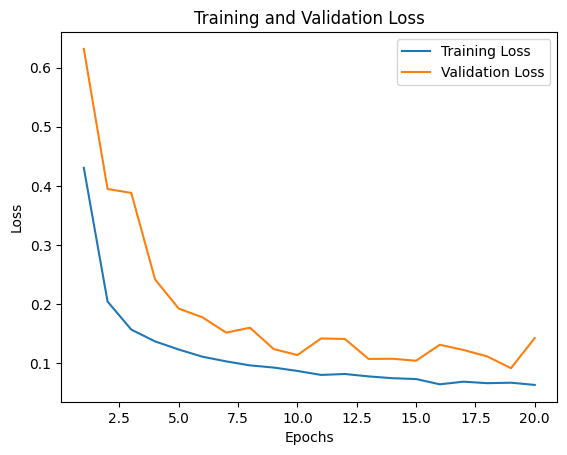

In [12]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = len(history.history['loss'])
# Plot the loss and val_loss
epochs_range = range(1, epochs + 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# predictions

In [13]:
# load best weights to model
mobilenetModel.load_weights(weight_path)

# make predictions
predictions = mobilenetModel.predict(test_dataset)
predictions

25/25 [==============================] - 20s 737ms/step


array([[9.9957448e-01, 7.9406136e-06, 4.1746121e-04, 1.4679498e-08],
       [9.9939835e-01, 2.3139933e-04, 3.7033038e-04, 2.8373570e-10],
       [8.9428979e-01, 8.3382882e-02, 2.2326196e-02, 1.1481636e-06],
       ...,
       [5.9556853e-05, 1.1815022e-09, 2.0001348e-06, 9.9993837e-01],
       [5.0946601e-02, 7.6873852e-07, 2.7003747e-03, 9.4635224e-01],
       [5.2168602e-03, 3.8338946e-08, 6.0657709e-04, 9.9417651e-01]],
      dtype=float32)

In [14]:
# we have to get the position of the maximum value from each sample.

predicted_class = np.argmax(predictions, axis=1)

              precision    recall  f1-score   support

           0       1.00      0.96      0.98       106
           1       0.96      0.81      0.88       234
           2       0.89      0.98      0.93       390
           3       1.00      1.00      1.00        41

    accuracy                           0.93       771
   macro avg       0.96      0.94      0.95       771
weighted avg       0.93      0.93      0.92       771

{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2, 'TURBERCULOSIS': 3}


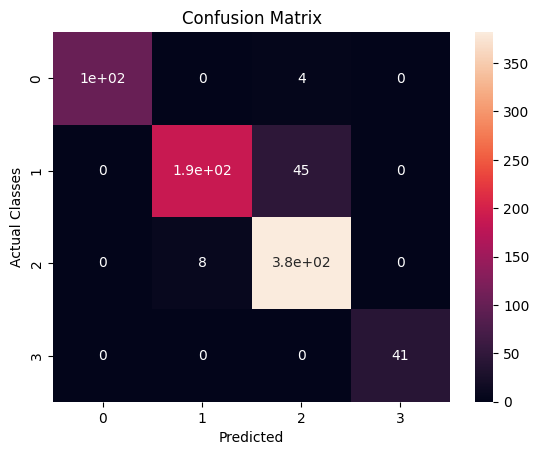

In [15]:
from sklearn.metrics import confusion_matrix, classification_report

true_labels = test_dataset.classes

sns.heatmap(confusion_matrix(true_labels, predicted_class), annot=True)

# Print classification report
print(classification_report(true_labels, predicted_class))
print(test_dataset.class_indices)

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual Classes')
plt.show()

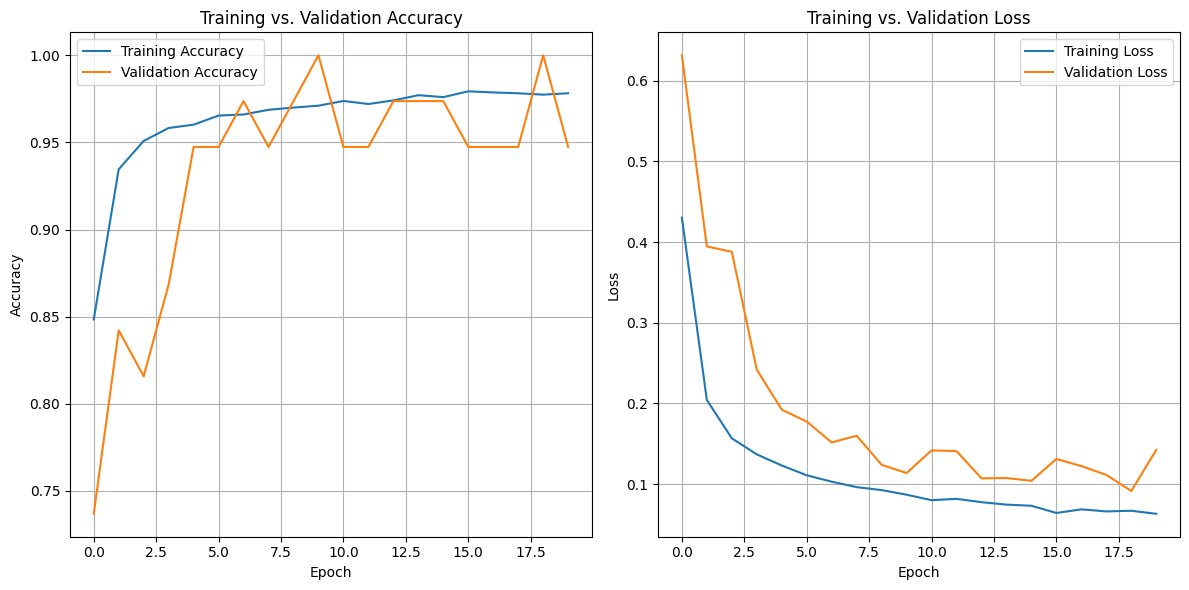

In [16]:
import matplotlib.pyplot as plt
# Assuming your history object is named 'history' and it contains 'accuracy' and 'val_accuracy' keys
plt.figure(figsize=(12, 6))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)  # Divide the figure into two subplots
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.legend()
plt.grid(True)

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()  # Adjust spacing between subplots for better readability
plt.show()

In [17]:
loss, accuracy = mobilenetModel.evaluate(test_dataset, verbose=1)
print(f'Accuracy: {accuracy*100}')

25/25 [==============================] - 12s 417ms/step - loss: 0.1998 - accuracy: 0.9261
Accuracy: 92.60700345039368


In [18]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score,ConfusionMatrixDisplay

M_Recall = recall_score(true_labels, predicted_class,average='weighted')
M_Precision = precision_score(true_labels, predicted_class,average='weighted')
M_f1 = f1_score(true_labels, predicted_class,average='weighted')
M_accuracy = accuracy_score(true_labels, predicted_class)

In [19]:
M_Recall,M_Precision,M_f1,M_accuracy

(0.9260700389105059,
 0.9301669453037172,
 0.9249155133307311,
 0.9260700389105059)

In [22]:
#Save Model

mobilenetModel.save('/kaggle/working/my_model.h5')